In [ ]:
# imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import warnings
from collections import Counter
from hyperopt import fmin, hp, STATUS_OK, tpe, Trials
from imblearn.over_sampling import ADASYN, SMOTE
from math import ceil
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif as mic
from sklearn.feature_selection import SelectPercentile
from sklearn.metrics import classification_report, recall_score, roc_auc_score, roc_curve, plot_confusion_matrix, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder

# Settings
pd.pandas.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


In [ ]:
# Functions
def train_test_split_chrono(X, y, test_size, dates):
    n_test = ceil(test_size * len(X))

    sorted_index = [x for _, x in sorted(zip(np.array(dates), np.arange(0, len(dates))), key=lambda pair: pair[0])]
    train_idx = sorted_index[:-n_test]
    test_idx = sorted_index[-n_test:]

    if isinstance(X, (pd.Series, pd.DataFrame)):
        X_train = X.iloc[train_idx]
        X_test = X.iloc[test_idx]
    else:
        X_train = X[train_idx]
        X_test = X[test_idx]
    if isinstance(y, (pd.Series, pd.DataFrame)):
        y_train = y.iloc[train_idx]
        y_test = y.iloc[test_idx]
    else:
        y_train = y[train_idx]
        y_test = y[test_idx]

    return X_train, X_test, y_train, y_test


def vif(feats, data):
    from sklearn.linear_model import LinearRegression
    
    # initialize dictionaries
    vif_dict, tolerance_dict = {}, {}

    # form input data for each exogenous variable
    for feat in feats:
        not_feat = [i for i in feats if i != feat]
        X, y = data[not_feat], data[feat]

        # extract r-squared from the fit
        r_squared = LinearRegression().fit(X, y).score(X, y)

        # calculate VIF
        vif = 1/(1 - r_squared)
        vif_dict[feat] = vif

        # calculate tolerance
        tolerance = 1 - r_squared
        tolerance_dict[feat] = tolerance

    # return VIF DataFrame
    df_vif = pd.DataFrame({'VIF': vif_dict, 'Tolerance': tolerance_dict})

    return df_vif


def evaluate_model(mode, y_true, y_pred, y_proba):
    print(f'=================== {mode} ===================')
        
    # Obtain ROC_AUC score
    roc_auc = roc_auc_score(y_true=y_true, y_score=y_proba[:,1])
    print(f'{mode} ROC_AUC score: ', round(roc_auc, 2))
    print(' ')
    
    report_train = classification_report(y_true,
                                         y_pred,
                                         target_names=['Legítima', 'Fraude'],
                                         output_dict=True)

    report_train = pd.DataFrame(report_train).transpose().apply(lambda x: x.apply('{0:.2f}'.format))
    print(report_train)


def get_confusion_matrix(mode, classifier, y_true, x_test):
    fig, ax = plt.subplots(1, 1, figsize = (6,4))

    plot_confusion_matrix(classifier, x_test, y_true, ax=ax, values_format='d')
    ax.set_title(f'Confusion Matrix - {mode} Dataset'); 
    ax.xaxis.set_ticklabels(['Legítima', 'Fraude']); ax.yaxis.set_ticklabels(['Legítima', 'Fraude']);
    plt.show()


def get_confusion_matrix_2(y_true, y_pred, class_names=None, normalize=None,
                          title='Confusion Matrix', plot_numbers=True, display_names=None,
                          figsize=(6, 4)):

    cm = confusion_matrix(y_true, y_pred, labels=class_names, normalize=normalize)
    
    if not display_names:
        display_names = class_names
    df_cm = pd.DataFrame(cm, index=display_names, columns=display_names)
    fig = plt.figure(figsize=figsize)
    sns.heatmap(df_cm, annot=plot_numbers, cmap='viridis', fmt='g')
    plt.setp(plt.gca().get_xticklabels(), ha="right", rotation=0)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title(title)
    
    plt.savefig('./conf_matrix_custom_tr', bbox_inches='tight', dpi=600)
    plt.show()

# Data Preprocessing

In [ ]:
# Loading the dataset into a pandas dataframe
df = pd.read_csv('./df_final.csv', encoding='utf-8')

In [ ]:
# Getting variables names
df.columns

Index(['trans_date_trans_time', 'merchant', 'category', 'amt', 'gender',
       'city', 'state', 'city_pop', 'unix_time', 'is_fraud', 'trans_hour',
       'trans_week_day', 'trans_month', 'age', 'coor_customer',
       'coor_merchant', 'dist_cus_merch', 'qty_purc_unti_now_store',
       'qty_purc_last_hour_merc', 'qty_purc_last_hour', 'mean_spet_last_day',
       'mean_spet_last_week', 'mean_spet_last_mont', 'sum_spet_last_mont'],
      dtype='object')

In [ ]:
df.drop(['merchant', 'coor_customer', 'coor_merchant', 'city', 'state'], axis=1, inplace=True)

In [ ]:
# Splitting the data in train and test sets
X_train, X_test, y_train, y_test = train_test_split_chrono(df.drop(['is_fraud', 'trans_date_trans_time'], axis=1),
                                                    df['is_fraud'],
                                                    test_size=0.3,
                                                    dates=df['trans_date_trans_time'])

In [ ]:
# Categorial features
cat_features = ['category', 'gender', 'trans_week_day', 'trans_month']

# Instantiate the encoder and fit
ohe = OneHotEncoder(handle_unknown='ignore')
ohe.fit(X_train[cat_features])

# Get feat names
columns_names = ohe.get_feature_names_out()

# Transforms the training features 
dummies_train = ohe.transform(X_train[cat_features])
dummies_train = pd.DataFrame.sparse.from_spmatrix(dummies_train, columns=columns_names)

# Enconding test set
dummies_test = ohe.transform(X_test[cat_features])
dummies_test = pd.DataFrame.sparse.from_spmatrix(dummies_test, columns=columns_names)

In [ ]:
# Reseting indexes
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

# Assembles transformed train dataset
X_train_dum = pd.concat([X_train, dummies_train], axis=1)
X_train_dum = X_train_dum.drop(cat_features, axis=1)

# Assembles transformed test dataset
X_test_dum = pd.concat([X_test, dummies_test], axis=1)
X_test_dum = X_test_dum.drop(cat_features, axis=1)

# Feature Selection - Mutual Information

In [ ]:
# Filtering method for feature selection
mutual_info = mic(X_train_dum, y_train)
mutual_info = pd.Series(mutual_info)
mutual_info.index = X_train_dum.columns
mutual_info.sort_values(ascending=False, inplace=True)
df_mi = pd.DataFrame(mutual_info, columns=['Mutual Information'])

Wall time: 19min 11s


In [ ]:
# Plot calculated MI
ax = df_mi.iloc[:12,:].plot.bar(figsize=(8, 6), color='gray')


ax.figure.savefig('./mutual_information.png', bbox_inches='tight', dpi=600)

In [ ]:
%%time

# Selecting best 25% features
percentile = SelectPercentile(mic, percentile=25).fit(X_train_dum, y_train)
percentile_features = X_train_dum.columns[percentile.get_support()]
print(f'===== {len(percentile_features)} features were selected =====')
print(f"{', '.join(percentile_features)}")

===== 12 features were selected =====
amt, trans_hour, qty_purc_unti_now_store, qty_purc_last_hour_merc, qty_purc_last_hour, mean_spet_last_day, mean_spet_last_week, gender_F, gender_M, trans_week_day_Monday, trans_week_day_Saturday, trans_week_day_Sunday
Wall time: 18min 5s


In [ ]:
# Filtering test set
X_train_new = X_train_dum[percentile_features]
X_test_new = X_test_dum[percentile_features]

In [ ]:
# Checking multicollinearity
df_vif = vif(feats=percentile_features, data=X_train_new)

# VIF for input dataset
df_vif.apply(lambda x: x.apply('{0:.1f}'.format))

,VIF,Tolerance
amt,1.5,0.7
trans_hour,1.0,1.0
qty_purc_unti_now_store,1.0,1.0
qty_purc_last_hour_merc,1.0,1.0
qty_purc_last_hour,1.0,1.0
mean_spet_last_day,1.8,0.6
mean_spet_last_week,1.3,0.8
gender_F,inf,0.0
gender_M,inf,0.0
trans_week_day_Monday,1.2,0.9


In [ ]:
# VIF greater than 5 are correlated
df_vif.drop(['gender_M'], axis=0, inplace=True)

In [ ]:
# Checking multicollinearity
df_vif = vif(feats=df_vif.index.values, data=X_train_new)

# VIF for input dataset
df_vif.apply(lambda x: x.apply('{0:.1f}'.format))

,VIF,Tolerance
amt,1.5,0.7
trans_hour,1.0,1.0
qty_purc_unti_now_store,1.0,1.0
qty_purc_last_hour_merc,1.0,1.0
qty_purc_last_hour,1.0,1.0
mean_spet_last_day,1.8,0.6
mean_spet_last_week,1.3,0.8
gender_F,1.0,1.0
trans_week_day_Monday,1.2,0.9
trans_week_day_Saturday,1.1,0.9


In [ ]:
# Filtering dataset with uncorrelated features
X_train_new = X_train_new[list(df_vif.index.values)]
X_test_new = X_test_new[list(df_vif.index.values)]

In [ ]:
# Filtering dataset with uncorrelated features
X_train_new = X_train_dum[subset]
X_test_new = X_test_dum[subset]

# ADASYN

In [ ]:
print('Original dataset shape %s' % Counter(y_train))

# Instatiates ADASYN
ada_over = ADASYN(sampling_strategy='minority', random_state=18)

X_ada, y_ada = ada_over.fit_resample(X_train_new, y_train)

print('Resampled dataset shape %s' % Counter(y_ada))

Original dataset shape Counter({0: 1291079, 1: 7506})
Resampled dataset shape Counter({0: 1291079, 1: 1291060})


# SMOTE

In [ ]:
print('Original dataset shape %s' % Counter(y_train))

# Instatiates SMOTE
smt_over = SMOTE(sampling_strategy='minority', random_state=18)

X_smt, y_smt = smt_over.fit_resample(X_train_new, y_train)

print('Resampled dataset shape %s' % Counter(y_smt))

Original dataset shape Counter({0: 1291079, 1: 7506})
Resampled dataset shape Counter({0: 1291079, 1: 1291079})


# Random Forest
## Random Forest + ADASYN

In [ ]:
# Defines input values to test 
space = {'max_depth': hp.choice('max_depth', range(4, 8, 1)),
         'max_features': hp.pchoice('max_features', [(0.5, 'sqrt'), # most common choice
                                                     (0.4, 'log2'), # less common choice
                                                     (0.1, None)]), # rare choice
         'min_samples_leaf': hp.quniform ('min_samples_leaf', 18, 26, 1),
         'min_samples_split' : hp.quniform ('min_samples_split', 22, 32, 1),
         'n_estimators' : hp.choice('n_estimators', range(50, 250, 10))}

In [ ]:
# Defines the loss function to minimize
def objective(space):
    # instantiate the algorithm
    rf_cl = RandomForestClassifier(n_estimators=int(space['n_estimators']),
                                   max_depth=int(space['max_depth']),
                                   max_features=space['max_features'],
                                   min_samples_split=int(space['min_samples_split']),
                                   min_samples_leaf=int(space['min_samples_leaf']),
                                   class_weight='balanced')
    
    # Cross validation
    cv_score = cross_val_score(estimator=rf_cl,
                               X=X_ada,
                               y=y_ada,
                               cv=3,
                               scoring='roc_auc',
                               n_jobs=-1,
                               error_score='raise')
    
    # Calculate roc_auc mean on the folds
    mean_cv_score = cv_score.mean()
    
    return {'loss': 1-mean_cv_score, 'status': STATUS_OK}

In [ ]:
# Searching for best params
trials = Trials()

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=5,
            trials=trials,
            rstate=np.random.default_rng(18),
            return_argmin=False)

100%|████████████████████████████████████████████████| 5/5 [28:52<00:00, 346.45s/trial, best loss: 0.00829816004632844]


In [ ]:
%%time

# Best Adasyn RF
ada_rf = RandomForestClassifier(n_estimators=best['n_estimators'],
                               max_depth=best['max_depth'],
                               max_features=best['max_features'],
                               min_samples_split=int(best['min_samples_split']),
                               min_samples_leaf=int(best['min_samples_leaf']),
                               class_weight='balanced',
                               n_jobs=-1,
                               random_state=18)

ada_rf.fit(X_ada, y_ada)

Wall time: 2min 46s


RandomForestClassifier(class_weight='balanced', max_depth=7,
                       min_samples_leaf=24, min_samples_split=28, n_jobs=-1,
                       random_state=18)

### Metrics

In [ ]:
# Predict dataset
train_pred_ada_rf = ada_rf.predict(X_ada)
train_proba_ada_rf = ada_rf.predict_proba(X_ada)
test_pred_ada_rf = ada_rf.predict(X_test_new)
test_proba_ada_rf = ada_rf.predict_proba(X_test_new)

In [ ]:
evaluate_model('TRAIN', y_ada, train_pred_ada_rf, train_proba_ada_rf)

=================== TRAIN ===================
TRAIN ROC_AUC score:  0.99
 
             precision recall f1-score     support
Legítima          0.96   0.97     0.96  1291079.00
Fraude            0.96   0.96     0.96  1291060.00
accuracy          0.96   0.96     0.96        0.96
macro avg         0.96   0.96     0.96  2582139.00
weighted avg      0.96   0.96     0.96  2582139.00


In [ ]:
evaluate_model('TEST', y_test, test_pred_ada_rf, test_proba_ada_rf)

=================== TEST ===================
TEST ROC_AUC score:  0.99
 
             precision recall f1-score    support
Legítima          1.00   0.97     0.98  554392.00
Fraude            0.10   0.94     0.18    2145.00
accuracy          0.97   0.97     0.97       0.97
macro avg         0.55   0.96     0.58  556537.00
weighted avg      1.00   0.97     0.98  556537.00


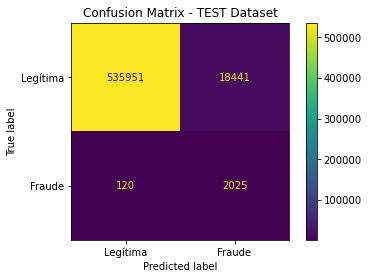

In [ ]:
get_confusion_matrix('TEST', ada_rf, y_test, X_test_new)

## Random Forest + SMOTE

In [ ]:
# Defines the loss function to minimize
def objective(space):
    # instantiate the algorithm
    rf_cl = RandomForestClassifier(n_estimators=int(space['n_estimators']),
                                   max_depth=int(space['max_depth']),
                                   max_features=space['max_features'],
                                   min_samples_split=int(space['min_samples_split']),
                                   min_samples_leaf=int(space['min_samples_leaf']),
                                   class_weight='balanced')
    
    # Cross validation
    cv_score = cross_val_score(estimator=rf_cl,
                               X=X_smt,
                               y=y_smt,
                               cv=3,
                               scoring='roc_auc',
                               n_jobs=-1,
                               error_score='raise')
    
    # Calculate roc_auc mean on the folds
    mean_cv_score = cv_score.mean()
    
    return {'loss': 1-mean_cv_score, 'status': STATUS_OK}

In [ ]:
# Searching for best params
trials = Trials()

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=5,
            trials=trials,
            rstate=np.random.default_rng(18),
            return_argmin=False)

100%|██████████████████████████████████████████████| 5/5 [32:38<00:00, 391.69s/trial, best loss: 0.0036231625901016473]


In [ ]:
%%time

# Best Smote RF
smt_rf = RandomForestClassifier(n_estimators=best['n_estimators'],
                               max_depth=best['max_depth'],
                               max_features=best['max_features'],
                               min_samples_split=int(best['min_samples_split']),
                               min_samples_leaf=int(best['min_samples_leaf']),
                               class_weight='balanced',
                               n_jobs=-1,
                               random_state=18)

smt_rf.fit(X_smt, y_smt)

Wall time: 3min 23s


RandomForestClassifier(class_weight='balanced', max_depth=7,
                       min_samples_leaf=24, min_samples_split=28, n_jobs=-1,
                       random_state=18)

### Metrics

In [ ]:
# Predict test dataset
train_pred_smt_rf = smt_rf.predict(X_smt)
train_proba_smt_rf = smt_rf.predict_proba(X_smt)
test_pred_smt_rf = smt_rf.predict(X_test_new)
test_proba_smt_rf = smt_rf.predict_proba(X_test_new)

In [ ]:
evaluate_model('TRAIN', y_smt, train_pred_smt_rf, train_proba_smt_rf)

=================== TRAIN ===================
TRAIN ROC_AUC score:  1.0
 
             precision recall f1-score     support
Legítima          0.97   0.98     0.97  1291079.00
Fraude            0.98   0.97     0.97  1291079.00
accuracy          0.97   0.97     0.97        0.97
macro avg         0.97   0.97     0.97  2582158.00
weighted avg      0.97   0.97     0.97  2582158.00


In [ ]:
evaluate_model('TEST', y_test, test_pred_ada_rf, test_proba_smt_rf)

=================== TEST ===================
TEST ROC_AUC score:  0.99
 
             precision recall f1-score    support
Legítima          1.00   0.97     0.98  554392.00
Fraude            0.10   0.94     0.18    2145.00
accuracy          0.97   0.97     0.97       0.97
macro avg         0.55   0.96     0.58  556537.00
weighted avg      1.00   0.97     0.98  556537.00


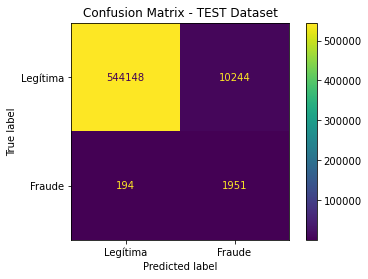

In [ ]:
get_confusion_matrix('TEST', smt_rf, y_test, X_test_new)

# XGBoost
## XGBoost + ADASYN

In [ ]:
# Defines input values to test 
space={'max_depth': hp.choice('max_depth', np.arange(2, 10, dtype=int)),
        'gamma': hp.quniform('gamma', 0, 1, 0.05),
        'reg_alpha': hp.quniform('reg_alpha', 40, 180, 1),
        'reg_lambda': hp.uniform('reg_lambda', 0, 1),
        'colsample_bytree' : hp.quniform('colsample_bytree', 0.1, 1.0, 0.05),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': hp.quniform('n_estimators', 10, 200, 5),
        'learning_rate' : hp.quniform('learning_rate', 0.01, 0.5, 0.01),
    }

In [ ]:
# Defines the loss function to minimize
def objective(space):
    # instantiate the algorithm
    ada_xgb = xgb.XGBClassifier(max_depth=space['max_depth'],
                                gamma=space['gamma'],
                                reg_alpha=space['reg_alpha'],
                                reg_lambda=space['reg_lambda'],
                                colsample_bytree=space['colsample_bytree'],
                                min_child_weight=space['min_child_weight'],
                                n_estimators=int(space['n_estimators']),
                                learning_rate=space['learning_rate'],
                                objective='binary:logistic')
    
    # Cross validation
    cv_score = cross_val_score(estimator=ada_xgb,
                               X=X_ada,
                               y=y_ada,
                               cv=3,
                               scoring='roc_auc',
                               n_jobs=-1,
                               error_score='raise')
    
    # Calculate roc_auc mean on the folds
    mean_cv_score = cv_score.mean()
    
    return {'loss': 1-mean_cv_score, 'status': STATUS_OK}

In [ ]:
# Searching for best params
trials = Trials()

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=5,
            trials=trials,
            rstate=np.random.default_rng(18),
            return_argmin=False)

100%|██████████████████████████████████████████████| 5/5 [20:36<00:00, 247.32s/trial, best loss: 0.0010796597624379567]


In [ ]:
%%time

# Best Adasyn XGB
ada_xgb = xgb.XGBClassifier(max_depth=int(best['max_depth']),
                            gamma=best['gamma'],
                            reg_alpha=best['reg_alpha'],
                            reg_lambda=best['reg_lambda'],
                            colsample_bytree=best['colsample_bytree'],
                            min_child_weight=best['min_child_weight'],
                            n_estimators=int(best['n_estimators']),
                            learning_rate=best['learning_rate'],
                            objective='binary:logistic',
                            n_jobs=-1,
                            random_state=18)

ada_xgb.fit(X_ada, y_ada)

[01:30:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 4min 41s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.55,
              gamma=0.15000000000000002, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.28, max_delta_step=0,
              max_depth=8, min_child_weight=1.0, missing=nan,
              monotone_constraints='()', n_estimators=95, n_jobs=-1,
              num_parallel_tree=1, random_state=18, reg_alpha=118.0,
              reg_lambda=0.03392680436423523, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

### Metrics

In [ ]:
# Predict test dataset
train_pred_ada_xgb = ada_xgb.predict(X_ada)
train_proba_ada_xgb = ada_xgb.predict_proba(X_ada)
test_pred_ada_xgb = ada_xgb.predict(X_test_new)
test_proba_ada_xgb = ada_xgb.predict_proba(X_test_new)

In [ ]:
evaluate_model('TRAIN', y_ada, train_pred_ada_xgb, train_proba_ada_xgb)

=================== TRAIN ===================
TRAIN ROC_AUC score:  1.0
 
             precision recall f1-score     support
Legítima          1.00   0.99     0.99  1291079.00
Fraude            0.99   1.00     0.99  1291060.00
accuracy          0.99   0.99     0.99        0.99
macro avg         0.99   0.99     0.99  2582139.00
weighted avg      0.99   0.99     0.99  2582139.00


In [ ]:
evaluate_model('TEST', y_test, test_pred_ada_xgb, test_proba_ada_xgb)

=================== TEST ===================
TEST ROC_AUC score:  0.99
 
             precision recall f1-score    support
Legítima          1.00   0.99     1.00  554392.00
Fraude            0.30   0.89     0.45    2145.00
accuracy          0.99   0.99     0.99       0.99
macro avg         0.65   0.94     0.72  556537.00
weighted avg      1.00   0.99     0.99  556537.00


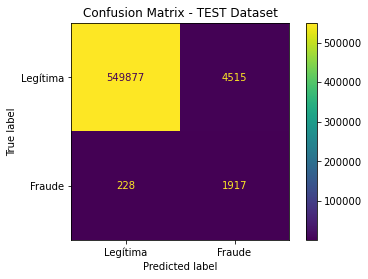

In [ ]:
get_confusion_matrix('TEST', ada_xgb, y_test, X_test_new)

## XGBoost + SMOTE

In [ ]:
# Defines the loss function to minimize
def objective(space):
    # instantiate the algorithm
    smt_xgb = xgb.XGBClassifier(max_depth=space['max_depth'],
                                gamma=space['gamma'],
                                reg_alpha=space['reg_alpha'],
                                reg_lambda=space['reg_lambda'],
                                colsample_bytree=space['colsample_bytree'],
                                min_child_weight=space['min_child_weight'],
                                n_estimators=int(space['n_estimators']),
                                learning_rate=space['learning_rate'],
                                objective='binary:logistic')
    
    # Cross validation
    cv_score = cross_val_score(estimator=smt_xgb,
                               X=X_smt,
                               y=y_smt,
                               cv=3,
                               scoring='roc_auc',
                               n_jobs=-1,
                               error_score='raise')
    
    # Calculate roc_auc mean on the folds
    mean_cv_score = cv_score.mean()
    
    return {'loss': 1-mean_cv_score, 'status': STATUS_OK}

In [ ]:
# Searching for best params
trials = Trials()

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=5,
            trials=trials,
            rstate=np.random.default_rng(18),
            return_argmin=False)

100%|██████████████████████████████████████████████| 5/5 [23:26<00:00, 281.40s/trial, best loss: 0.0003413230049497118]


In [ ]:
%%time

# Best Adasyn XGB
smt_xgb = xgb.XGBClassifier(max_depth=int(best['max_depth']),
                            gamma=best['gamma'],
                            reg_alpha=best['reg_alpha'],
                            reg_lambda=best['reg_lambda'],
                            colsample_bytree=best['colsample_bytree'],
                            min_child_weight=best['min_child_weight'],
                            n_estimators=int(best['n_estimators']),
                            learning_rate=best['learning_rate'],
                            objective='binary:logistic',
                            n_jobs=-1,
                            random_state=18)

smt_xgb.fit(X_smt, y_smt)

[09:22:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 5min 2s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.55,
              gamma=0.15000000000000002, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.28, max_delta_step=0,
              max_depth=8, min_child_weight=1.0, missing=nan,
              monotone_constraints='()', n_estimators=95, n_jobs=-1,
              num_parallel_tree=1, random_state=18, reg_alpha=118.0,
              reg_lambda=0.03392680436423523, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

### Metrics

In [ ]:
# Predict test dataset
train_pred_smt_xgb = smt_xgb.predict(X_smt)
train_proba_smt_xgb = smt_xgb.predict_proba(X_smt)
test_pred_smt_xgb = smt_xgb.predict(X_test_new)
test_proba_smt_xgb = smt_xgb.predict_proba(X_test_new)

In [ ]:
evaluate_model('TRAIN', y_smt, train_pred_smt_xgb, train_proba_smt_xgb)

=================== TRAIN ===================
TRAIN ROC_AUC score:  1.0
 
             precision recall f1-score     support
Legítima          0.99   0.99     0.99  1291079.00
Fraude            0.99   0.99     0.99  1291079.00
accuracy          0.99   0.99     0.99        0.99
macro avg         0.99   0.99     0.99  2582158.00
weighted avg      0.99   0.99     0.99  2582158.00


In [ ]:
evaluate_model('TEST', y_test, test_pred_smt_xgb, test_proba_smt_xgb)

=================== TEST ===================
TEST ROC_AUC score:  0.99
 
             precision recall f1-score    support
Legítima          1.00   0.99     1.00  554392.00
Fraude            0.37   0.88     0.52    2145.00
accuracy          0.99   0.99     0.99       0.99
macro avg         0.68   0.93     0.76  556537.00
weighted avg      1.00   0.99     0.99  556537.00


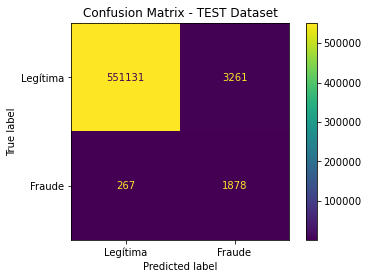

In [ ]:
get_confusion_matrix('TEST', smt_xgb, y_test, X_test_new)

# ROC Curves

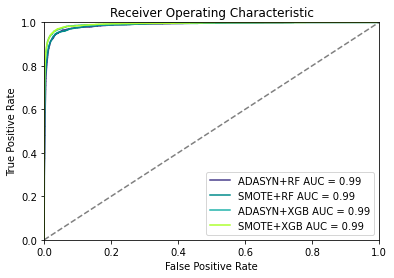

In [ ]:
# ROC_AUC scores
ada_rf_roc_auc = roc_auc_score(y_true=y_test, y_score=test_proba_ada_rf[:,1]) # ADASYN + Random Forest
smt_rf_roc_auc = roc_auc_score(y_true=y_test, y_score=test_proba_smt_rf[:,1]) # SMOTE + Random Forest
ada_xgb_roc_auc = roc_auc_score(y_true=y_test, y_score=test_proba_ada_xgb[:,1]) # ADASYN + XGBoost
smt_xgb_roc_auc = roc_auc_score(y_true=y_test, y_score=test_proba_smt_xgb[:,1]) # SMOTE + XGBoost

# Calculate true/false positive rate and thresholds
fpr_ada_rf, tpr_ada_rf, thresholds_ada_rf = roc_curve(y_true=y_test, y_score=test_proba_ada_rf[:,1], pos_label=1)
fpr_smt_rf, tpr_smt_rf, thresholds_smt_rf = roc_curve(y_true=y_test, y_score=test_proba_smt_rf[:,1], pos_label=1)
fpr_ada_xgb, tpr_ada_xgb, thresholds_ada_xgb = roc_curve(y_true=y_test, y_score=test_proba_ada_xgb[:,1], pos_label=1)
fpr_smt_xgb, tpr_smt_xgb, thresholds_smt_xgb = roc_curve(y_true=y_test, y_score=test_proba_smt_xgb[:,1], pos_label=1)

# Plot roc curve
plt.plot(fpr_ada_rf, tpr_ada_rf, 'b', label = 'ADASYN+RF AUC = %0.2f' % ada_rf_roc_auc, color='darkslateblue')
plt.plot(fpr_smt_rf, tpr_smt_rf, 'b', label = 'SMOTE+RF AUC = %0.2f' % smt_rf_roc_auc, color='darkcyan')
plt.plot(fpr_ada_xgb, tpr_ada_xgb, 'b', label = 'ADASYN+XGB AUC = %0.2f' % ada_xgb_roc_auc, color='lightseagreen')
plt.plot(fpr_smt_xgb, tpr_smt_xgb, 'b', label = 'SMOTE+XGB AUC = %0.2f' % smt_xgb_roc_auc, color='greenyellow')

plt.plot([0, 1], [0, 1], 'r--', color='gray')
plt.xlim([0, 1])
plt.ylim([0, 1])

plt.title('Receiver Operating Characteristic')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')

plt.savefig('./roc_curves', bbox_inches='tight', dpi=600)
plt.show()

## Custom Threshold

In [ ]:
# Examples
threshold = 0.28



labels = (test_proba_smt_xgb[:,1] >= threshold).astype('int')

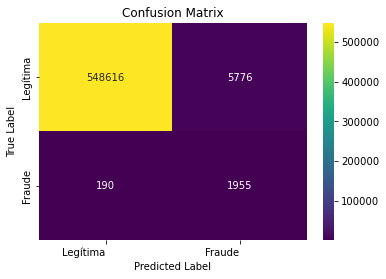

In [ ]:
get_confusion_matrix_2(y_test, labels, display_names=['Legítima', 'Fraude'])

In [ ]:
evaluate_model('TEST', y_test, labels, test_proba_smt_xgb)

=================== TEST ===================
TEST ROC_AUC score:  0.99
 
             precision recall f1-score    support
Legítima          1.00   0.99     0.99  554392.00
Fraude            0.25   0.91     0.40    2145.00
accuracy          0.99   0.99     0.99       0.99
macro avg         0.63   0.95     0.70  556537.00
weighted avg      1.00   0.99     0.99  556537.00


## Feature Importance

importance_type

‘weight’ - the number of times a feature is used to split the data across all trees.

‘gain’ - the average gain across all splits the feature is used in.

‘cover’ - the average coverage across all splits the feature is used in.

‘total_gain’ - the total gain across all splits the feature is used in.

‘total_cover’ - the total coverage across all splits the feature is used in.

In [ ]:
# Get feature importance
feature_important = smt_xgb.get_booster().get_score(importance_type='gain')
keys = list(feature_important.keys())
values = list(feature_important.values())
data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)

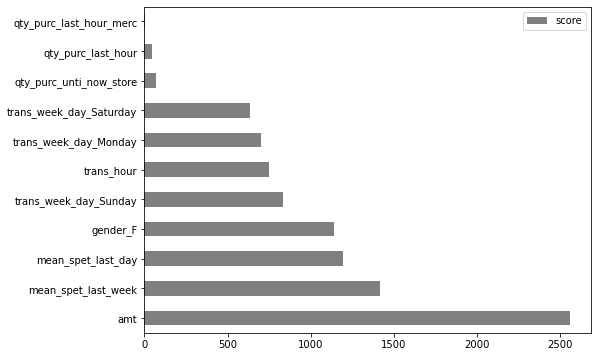

In [ ]:
ax = data.nlargest(11, columns="score").plot(kind='barh', figsize = (8, 6), color='gray')

ax.figure.savefig('./feature_importance.png', bbox_inches='tight', dpi=600)